# ModelConductor demo

This short tutorial will cover the basic workflow of conducting One-To-One experiments with ModelConductor. The experiment has two distinct parts, i.e. 

1) The process of writing high-frequency process data to an SQLite database is simulated with a mockup function and

2) The database is concurrently polled and the latest database streamed to a dynamical simulation model, distributed as an Functional Mockup Unit (FMU). The model's output is saved to a csv file

The FMU Model is implemented originally in MapleSim and taken from https://github.com/modelica/fmi-cross-check/tree/master/fmus/2.0/cs/win64/MapleSim/2018/CoupledClutches

The input file to the FMU has been trimmed down to first 1.4 seconds (approx. 1400 samples)

For a more detail description of the various ModelConductor components, read the code or see the original publication in [1]

[1] Aho, P. 2019. An Open Source Digital Twin Framework. Master's Thesis. Tampere University

# Preliminaries

Let us examine what we have, i.e., the FMU model and input data. 

In [1]:
from fmpy import dump

In [2]:
dump('CoupledClutches.fmu')


Model Info

  FMI Version       2.0
  FMI Type          Co-Simulation
  Model Name        CoupledClutches
  Description       Model CoupledClutches
  Platforms         win64
  Continuous States 8
  Event Indicators  25
  Variables         148
  Generation Tool   MapleSim (1357016/1357197/1357197)
  Generation Date   2018-10-25T13:27:07Z

Default Experiment

  Stop Time         1.5
  Step Size         0.01

Variables (input, output)

Name                Causality              Start Value  Unit     Description
inputs              input      0.00000000000000000e+00           RI1
outputs[1]          output     1.00000000000000000e+01  rad/s    J1.w
outputs[2]          output     0.00000000000000000e+00  rad/s    J2.w
outputs[3]          output     0.00000000000000000e+00  rad/s    J3.w
outputs[4]          output     0.00000000000000000e+00  rad/s    J4.w


At each timestep, the model accepts one input and produced an output vector of four elements. The expected step size is 0.01 seconds.

Example input data is contained in a csv file:  

In [3]:
# read in the raw data
import pandas as pd
data = pd.read_csv("CoupledClutches_in_sh.csv")

In [4]:
data.head()

,time,inputs
0,0.000,0
1,0.001,0
2,0.002,0
3,0.003,0
4,0.004,0


In [5]:
len(data)

1421

In [6]:
from matplotlib import pyplot as plt

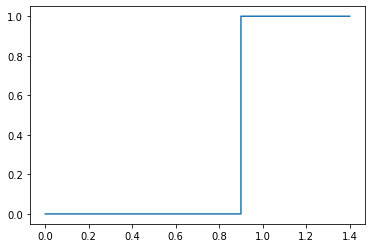

In [7]:
plt.plot(data["time"], data["inputs"])

The input data is essentially a stair function (Clutch engaged / disengaged?)

Let's check the mean time step

In [8]:
data["time"].diff().mean()

0.0009859154761677057

The mean step should be in good accordance with what the model expects

## Receive loop

Using the MQTT experiment class, a broker will be started and one subscriber will be subscribing to the sample messages arriving from the measurements publisher.

## Model loop

The FMU model is wrapped with a corresponding ModelConductor component, thereafter operating on a 'pull' manner. Whenever a previously unseen datapoint is identified as a result of database poll operation, it is relayed to the corresponding ModelHandler component  

In [9]:
from modelconductor.modelhandler import FMUModelHandler

Within ModelConductor, all data that is to be exchanged from one data source / data consumer to another, is asserted to exists in one of two possible formats: 

i) A Measurement object that denotes a timestamped data structure that is received from a physical asset, best understood as a snapshot of the asset’s state at a given time or

ii) a ModelResponse object that similarly denotes a timestamped data structure that is received from a digital asset, a snapshot of the model’s virtual state at a given time 

A variable (a key) may, but is not required to belong to one or more of the following categories:

1) Input keys: The subset of keys in Measurement object corresponding to the keys that are expected as  inputs by the relevant ModelHandler

2) Target keys: The keys that are expected to be output from a ModelHandler instance onto a ModelResponse object

3) Control keys: A subset of keys in Measurement that is not intended to be used as an input to a ModelHandler, but rather as a validation variable against the ModelHandler output

4) Timestamp key: A key denoting the instant when the relevant Measurement or ModelResponce instance was created.


In [10]:
target_keys = ["outputs[1]",
               "outputs[2]",
               "outputs[3]",
               "outputs[4]"]
input_keys = ["inputs"]
control_keys = ["time"]
timestamp_key = "time"

Now the ModelHandler object can be instantiated:

In [11]:
model=FMUModelHandler(
    fmu_path='CoupledClutches.fmu',
    start_time=0,
    stop_time=1.5,
    step_size=0.01,
    target_keys=target_keys,
    input_keys=input_keys,
    control_keys=control_keys,
    timestamp_key=timestamp_key)

## The experiment
The experiment object will use the model inside its subscriber. The broker will start for listening to new measurements from publishers and the subscriber will be listening for new measurements which comes from the broker.

In [12]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

from modelconductor.experiment_mqtt import MqttExperiment

Experiment._run
Experiment._run


In [13]:
ex = MqttExperiment(logging=True)
ex.model = model
headers = ["timestamp"]
if ex.model.input_keys:
    headers += ex.model.input_keys
if ex.model.target_keys:
    headers += ex.model.target_keys
if ex.model.control_keys:
    headers += ex.model.control_keys
ex.logger = ex.initiate_logging(headers=headers)

## Run
Run the receiving loop. When it succeeded starting run the client on another process with this command:
```bash
python client_mqtt.py
```

In [14]:
ex.run()

[2020-10-22 16:21:22,709] :: INFO - Finished processing state new exit callbacks.
[2020-10-22 16:21:22,710] :: INFO - Finished processing state starting enter callbacks.
[2020-10-22 16:21:22,711] :: INFO - Listener 'default' bind to 0.0.0.0:1883 (max_connections=-1)
[2020-10-22 16:21:22,711] :: INFO - Finished processing state starting exit callbacks.
[2020-10-22 16:21:22,711] :: INFO - Finished processing state started enter callbacks.


Experiment._run.wrapper


[2020-10-22 16:21:24,735] :: INFO - Listener 'default': 1 connections acquired
[2020-10-22 16:21:24,736] :: INFO - Connection from 127.0.0.1:58147 on listener 'default'
[2020-10-22 16:21:24,738] :: INFO - Finished processing state new exit callbacks.
[2020-10-22 16:21:24,739] :: INFO - Finished processing state connected enter callbacks.
[2020-10-22 16:21:24,740] :: INFO - Finished processing state new exit callbacks.
[2020-10-22 16:21:24,741] :: INFO - Finished processing state connected enter callbacks.


0
1.5
2.0


[2020-10-22 16:21:49,293] :: INFO - Listener 'default': 2 connections acquired
[2020-10-22 16:21:49,295] :: INFO - Connection from 127.0.0.1:58157 on listener 'default'
[2020-10-22 16:21:49,301] :: INFO - Finished processing state new exit callbacks.
[2020-10-22 16:21:49,303] :: INFO - Finished processing state connected enter callbacks.


{'time': 0.0, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372909.3101053}
result: 
{'inputs': 0.0, 'outputs[1]': 9.900000031706817, 'outputs[2]': 0.09999996829318347, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0, 'TIMING_model_response_timestamp': 1603372909.313099}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372909.412676}
result: 
{'inputs': 0.0, 'outputs[1]': 9.830908657760922, 'outputs[2]': 0.19999304167657272, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.001, 'TIMING_model_response_timestamp': 1603372909.4174213}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0020000001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372909.5181217}
result: 
{'inputs': 0.0, 'outputs[1]': 9.764790934386207, 'outputs[2]': 0.29998455707581756, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.

{'time': 0.0219999999, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372911.689274}
result: 
{'inputs': 0.0, 'outputs[1]': 8.99559845112587, 'outputs[2]': 2.2992445483906137, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0219999999, 'TIMING_model_response_timestamp': 1603372911.6919878}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.023, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372911.7911878}
result: 
{'inputs': 0.0, 'outputs[1]': 8.980108914736487, 'outputs[2]': 2.399166877161863, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.023, 'TIMING_model_response_timestamp': 1603372911.8021593}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0240000002, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372911.9012291}
result: 
{'inputs': 0.0, 'outputs[1]': 8.966265819445937, 'outputs[2]': 2.499084175152807, 'outputs[3]': 0.0, 'outputs[4]': 0.

{'time': 0.0439999998, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372914.0822237}
result: 
{'inputs': 0.0, 'outputs[1]': 8.895687551581833, 'outputs[2]': 4.49613075178305, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0439999998, 'TIMING_model_response_timestamp': 1603372914.0852172}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0450000018, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372914.1851578}
result: 
{'inputs': 0.0, 'outputs[1]': 8.895123803620343, 'outputs[2]': 4.595905969954736, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0450000018, 'TIMING_model_response_timestamp': 1603372914.195864}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0460000001, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372914.295368}
result: 
{'inputs': 0.0, 'outputs[1]': 8.894125918371364, 'outputs[2]': 4.695672688378613, 'outputs[3]': 0.0, 'out

{'time': 0.0649999976, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372916.311962}
result: 
{'inputs': 0.0, 'outputs[1]': 8.668343158224099, 'outputs[2]': 6.589415941550273, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0649999976, 'TIMING_model_response_timestamp': 1603372916.4821498}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0659999996, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372916.5842593}
result: 
{'inputs': 0.0, 'outputs[1]': 8.639490182655502, 'outputs[2]': 6.688979600568984, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0659999996, 'TIMING_model_response_timestamp': 1603372916.5970256}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2
{'time': 0.0670000017, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372916.695598}
result: 
{'inputs': 0.0, 'outputs[1]': 8.608393040148743, 'outputs[2]': 6.7885314545846605, 'outputs[3]': 0.0, 'o

[2020-10-22 16:21:58,368] :: INFO - Finished processing state connected exit callbacks.
[2020-10-22 16:21:58,369] :: INFO - Finished processing state disconnected enter callbacks.
[2020-10-22 16:21:58,370] :: INFO - Listener 'default': 1 connections acquired


{'time': 0.0790000036, 'inputs': 0.0, 'TIMING_client_request_timestamp': 1603372918.3338134}
result: 
{'inputs': 0.0, 'outputs[1]': 8.03806633775673, 'outputs[2]': 7.9821757106767794, 'outputs[3]': 0.0, 'outputs[4]': 0.0, 'time': 0.0790000036, 'TIMING_model_response_timestamp': 1603372918.3357046}
logging to: <_io.TextIOWrapper name='exp_2020-10-22_16-21-22.log' mode='w+' encoding='cp1252'>
1
2


[2020-10-22 16:22:02,159] :: INFO - Finished processing state started exit callbacks.
[2020-10-22 16:22:02,160] :: INFO - Finished processing state stopping enter callbacks.
[2020-10-22 16:22:02,161] :: INFO - Broker closed
[2020-10-22 16:22:02,162] :: INFO - Finished processing state stopping exit callbacks.
[2020-10-22 16:22:02,163] :: INFO - Finished processing state stopped enter callbacks.


## Results
A crucial point of interest in the timeline of a ModelConductor Experiment is the instant when the ModelResponse object is returned, concluding a single iteration of the model loop depicted in Figure 17. At this point, the contents of ModelResponse of the time step are written to an external file as comma separated values, ordered in the following manner:
timestamp ,input\_keys ,target\_keys ,control\_keys

Let's examine the results of the experiment

In [15]:
print(ex.log_path)
pd.options.display.float_format = '{:.5f}'.format

results = pd.read_csv(ex.log_path)
results.head()

exp_2020-10-22_16-21-22.log


,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time
0,2020-10-22 16:21:49.316089,0.00000,9.90000,0.10000,0.00000,0.00000,0.00000
1,2020-10-22 16:21:49.419414,0.00000,9.83091,0.19999,0.00000,0.00000,0.00100
2,2020-10-22 16:21:49.526642,0.00000,9.76479,0.29998,0.00000,0.00000,0.00200
3,2020-10-22 16:21:49.643017,0.00000,9.70161,0.39997,0.00000,0.00000,0.00300
4,2020-10-22 16:21:49.750036,0.00000,9.64134,0.49996,0.00000,0.00000,0.00400


In [16]:
len(results)

80

Plot the simulation outputs

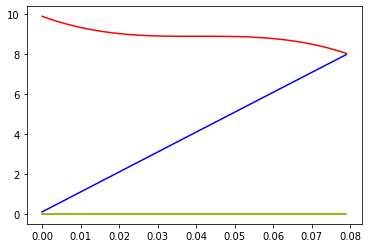

In [17]:
plt.plot(results["time"], results["outputs[1]"], 'r',
         results["time"], results["outputs[2]"], 'b',
         results["time"], results["outputs[3]"],  'g',
         results["time"], results["outputs[4]"], 'y')
plt.show()

Plot the inputs

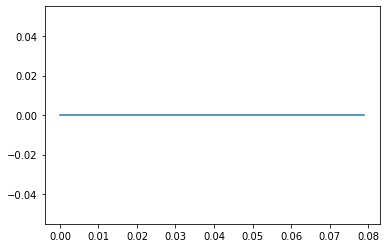

In [18]:
plt.plot(results["time"], results["inputs"])

A log entry is written each time a ModelResponse object is received from the FMUModelHandler instance. Having a priori knowledge about how much the simulated time advances between two consecutive ModelResponses (in this case, approximately 0.001 seconds) allows to define the following:

t = simulated time elapsed since beginning of the experiment

tau = wall-clock time elapsed since beginning of the experiment

t/tau = real-time performance coefficient

Let's plot the t/tau metric for the current demo (slight preprocessing involved)

In [19]:
results['timestamp'] = pd.to_datetime(results['timestamp'])

In [20]:
results['elapsed_wallclock'] = pd.to_timedelta(results['timestamp']).dt.total_seconds() - \
pd.to_timedelta(results['timestamp']).dt.total_seconds().iloc[0]

c:\users\sajad20h\appdata\local\programs\python\python37\lib\site-packages\pandas\util\_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [21]:
results.head()

,timestamp,inputs,outputs[1],outputs[2],outputs[3],outputs[4],time,elapsed_wallclock
0,2020-10-22 16:21:49.316089,0.00000,9.90000,0.10000,0.00000,0.00000,0.00000,0.00000
1,2020-10-22 16:21:49.419414,0.00000,9.83091,0.19999,0.00000,0.00000,0.00100,0.10332
2,2020-10-22 16:21:49.526642,0.00000,9.76479,0.29998,0.00000,0.00000,0.00200,0.21055
3,2020-10-22 16:21:49.643017,0.00000,9.70161,0.39997,0.00000,0.00000,0.00300,0.32693
4,2020-10-22 16:21:49.750036,0.00000,9.64134,0.49996,0.00000,0.00000,0.00400,0.43395


In [22]:
t_per_tau = results["time"].divide(results["elapsed_wallclock"])

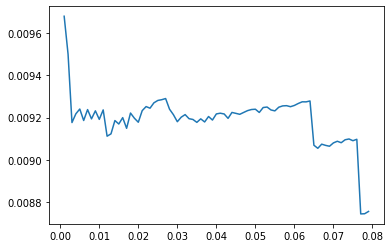

In [23]:
plt.plot(results["time"], t_per_tau)
plt.show()

## Discussion

Obviously the performance is very poor with the database operations as the bottleneck. Things could be improved substantially by introducing another means of accessing the input data, e.g., a TCP socket or similar.

See the original publication in [1] for further discussion